In [95]:
import numpy as np 
from numba import jit

import matplotlib.pyplot as plt

import cProfile

In [96]:
# supporting function

# def gauss(A=1, w=10**-3, x0=0, y0=0):
#     return lambda x,y: A*np.exp(-((x-x0)**2 + (y-y0)**2)/w**2)

@jit(nopython=True)
def gen_gauss(r0, r1, w=10**-3, x0=0, y0=0):
    ph = 2*np.pi*r0
    radius = w*np.sqrt(-np.log(r1))
    return x0 + np.cos(ph) * radius, y0 + np.sin(ph) * radius

@jit(nopython=True)
def gen_cyrcle(r0, r1, w=10**-3, x0=0, y0=0):
    ph = 2*np.pi*r0
    radius = w*r1
    return x0 + np.cos(ph) * radius, y0 + np.sin(ph) * radius

@jit(nopython=True)
def generator(generator_distribution, n, radiation_output):
    p = np.zeros(8)
    
    # coordinate and angulary distribution
    if generator_distribution == 'Gauss':
        p[0], p[1] = gen_gauss(np.random.random(1)[0],np.random.random(1)[0])
        p[5] = 1
    elif generator_distribution == 'Cyrcle':
        p[0], p[1] = gen_cyrcle(np.random.random(1)[0],np.random.random(1)[0])
        p[5] = 1
    else:
        p[5] = 1

    # start mass with frenel reflection
    r = R_frenel(np.arccos(p[5]), 1, n)
    p[6] = 1 - r
    
    # start layer
    p[7] = 0
    
    # collimated reflection radiation record
    if len(radiation_output) == 4:
        radiation_output[-1] += r
    
    return p

@jit(nopython=True)
def turn(old_p, g):
    p = old_p * 1.
    th = np.arccos(1/2/g*(1+g**2-((1-g**2)/(1-g+2*g*np.random.random(1)[0]))**2))
    ph = 2*np.pi*np.random.random(1)[0]
    
    sin_th = np.sin(th)
    cos_th = np.cos(th)
    sin_ph = np.sin(ph)
    cos_ph = np.cos(ph)
    
    if p[5] != 1. and p[5] != -1.:
        cx = (sin_th*(p[3]*p[5]*cos_ph-p[4]*sin_ph))/(np.sqrt(1-p[5]**2))+p[3]*cos_th
        cy = (sin_th*(p[4]*p[5]*cos_ph+p[3]*sin_ph))/(np.sqrt(1-p[5]**2))+p[4]*cos_th
        cz = -(np.sqrt(1-p[5]**2))*sin_th*cos_ph+p[5]*cos_th
    if p[5] == 1.:
        cx = sin_th*cos_ph
        cy = sin_th*sin_ph
        cz = cos_th
    if p[5] == -1.:
        cx = sin_th*cos_ph
        cy = -sin_th*sin_ph
        cz = -cos_th
    
    p[3],p[4],p[5]= cx, cy, cz
    
    return p

@jit(nopython=True)
def term(old_p):
    p = old_p * 1.
    threshold_m = 10**-4
    threshold_factor = 10
    if (p[6] < threshold_m) & (p[6] != 0.):
        if np.random.random(1)[0]<=1/threshold_factor:
            p[6] = threshold_m * threshold_factor
        else:
            p[6] = 0.
    return p

@jit(nopython=True)
def reflection(old_p, n_table):
    p = old_p * 1.
    layer_number = len(n_table)
    layer_index = int(p[-1])
    n1 = n_table[layer_index]
    
    if (layer_index == layer_number - 1) and (p[5] > 0):
        n2 = 1
        buf = -2
    elif (layer_index != layer_number - 1) and (p[5] > 0):
        n2 = n_table[layer_index + 1]
        buf = layer_index + 1
    elif (layer_index == 0) and (p[5] < 0):
        n2 = 1 
        buf = -1
    else:
        n2 = n_table[layer_index - 1]
        buf = layer_index - 1
    
    if np.random.random(1)[0] < R_frenel(np.arccos(p[5]), n1,n2):
        p[5] = -p[5]
    else:
        p[5] = np.sqrt(1 - (n1/n2)**2 * (1 - p[5]**2)) * np.sign(p[5])
        p[-1] = buf
        
    return p
        
@jit(nopython=True)
def R_frenel(th, n1,n2):
    if th>np.pi/2:
        th = np.pi-th
    
    n = n1/n2
    cos_th1 = np.cos(th)
    cos_th2 = np.cos(np.arcsin(n*np.sin(th)))
    
    def rs(cos_th1, cos_th2, n1, n2):
        a = n1*cos_th1-n2*cos_th2
        b = n1*cos_th1+n2*cos_th2
        return a/b
    def rp(cos_th1, cos_th2, n1, n2):
        a = n2*cos_th1-n1*cos_th2
        b = n2*cos_th1+n1*cos_th2
        return a/b    
    if np.sin(th) >= n2/n1:
        res = 1.
    else:
        res = 0.5 * ((rs(cos_th1, cos_th2, n1, n2))**2 + 
                     (rp(cos_th1, cos_th2, n1, n2))**2)
    if res < 1e-6:
        res = 0.
    return res

@jit(nopython=True)
def move(old_p, z_start_table, z_end_table, n_table, mu_a_table, mu_s_table, absorbtion_output):
    p = old_p * 1.
    
    if len(absorbtion_output) == 1:
        buf_m = p[6]
    
    # Cacl random non-dimensional l
    l_rand = -np.log(np.random.random(1))[0]

    while l_rand > 0.:
        layer_index = int(p[-1])
        z_start = z_start_table[layer_index]
        z_end = z_end_table[layer_index]

        mu_a = mu_a_table[layer_index]
        mu_s = mu_s_table[layer_index]
        mu_t = mu_a + mu_s

        l_free_path = 1 / mu_t
        l = l_rand * l_free_path

        new_p_z = (p[2] + l * p[5])
        if z_start < new_p_z < z_end:
            # non layer bound interaction
            new_p_x = (p[0] + l * p[3])
            new_p_y = (p[1] + l * p[4])
            p[0], p[1], p[2] = new_p_x, new_p_y, new_p_z
            p[6] = (p[6] * np.exp(-mu_a * l))
            break
        else:
            # layer boundary interaction

            # Cacl partial moving
            if p[5] > 0:
                l_part = ((z_end - p[2]) / p[5])
            else:
                l_part = ((z_start - p[2]) / p[5])

            # Cacl new random non-dimensional l
            l_rand = l_rand - mu_t * l_part

            # Cacl new coordinate (on boundary)
            new_p_x = (p[0] + l_part * p[3])
            new_p_y = (p[1] + l_part * p[4])
            new_p_z = (p[2] + l_part * p[5])

            p[0], p[1], p[2] = new_p_x, new_p_y, new_p_z
            p[6] = (p[6] * np.exp(-mu_a * l_part))

            # Check reflection (change layer)
            p = reflection(p, n_table)
            if (p[-1] == -1 or p[-1] == -2):
                break
    
    if len(absorbtion_output) == 1:
        absorbtion_output[0] += buf_m - p[6]
    
    return p

In [97]:
# engin function

def mlmc(parameters, geometry):
    N = parameters['N']
    generator_distribution = parameters['generator_distribution']
    
    layers_number = len(geometry)
    z_start_table = np.array([geometry[i]['z_start']  for i in range(layers_number)])
    z_end_table = np.array([geometry[i]['z_end']  for i in range(layers_number)])
    n_table = np.array([geometry[i]['n']  for i in range(layers_number)])
    mu_a_table = np.array([geometry[i]['mu_a']  for i in range(layers_number)])
    mu_s_table = np.array([geometry[i]['mu_s']  for i in range(layers_number)])
    g_table = np.array([geometry[i]['g']  for i in range(layers_number)])
    
    
    if parameters['absorbtion_saving_mode'] == 'Full':
        absorbtion_output = np.zeros(1)
    elif parameters['absorbtion_saving_mode'] == 'Mapping':
        pass #to do mesh
    
    
    if parameters['radiation_saving_mode'] == 'FIS':
        radiation_output = np.zeros(4)
        cz_collimate = parameters['FIS_collimated_aperture']
        @jit(nopython=True)
        def radiation_saving(p, radiation_output, cz_collimate=cz_collimate):
            cz = p[5]
            m = p[6]

            if cz > cz_collimate:
                radiation_output[0] += m
            elif cz > 0:
                radiation_output[1] += m
            elif cz > -cz_collimate:
                radiation_output[2] += m
            else:
                radiation_output[3] += m
            return radiation_output 
        
    elif parameters['radiation_saving_mode'] == 'MIS':
        radiation_output = np.concatenate(([parameters['MIS_positions_table']], 
                                           np.zeros((2, len(parameters['MIS_positions_table'])))), axis=0)
        sphere_d = 80
        port_d = 12.5
        @jit(nopython=True)
        def radiation_saving(p, radiation_output, sphere_d=sphere_d, port_d=port_d):
            for i in range(len(radiation_output[0])):
                if p[-1] == -2:
                    px = p[0] + radiation_output[0, i] * p[3]
                    py = p[1] + radiation_output[0, i] * p[4]
                    if 4 * (px**2 + py**2) < port_d**2:
                        radiation_output[1, i] += p[6]
                elif p[-1] == -1:
                    px = p[0] + radiation_output[0, i] * p[3]
                    py = p[1] + radiation_output[0, i] * p[4]
                    pxd = p[0] + (radiation_output[0, i] + sphere_d) * p[3]
                    pyd = p[1] + (radiation_output[0, i] + sphere_d) * p[4]
                    if (4 * (px**2 + py**2) < port_d**2) and (4 * (pxd**2 + pyd**2) > port_d**2):
                        radiation_output[2, i] += p[6]
            return radiation_output
        
    elif parameters['radiation_saving_mode'] == 'MIS_Thorlabs':
        radiation_output = np.concatenate(([parameters['MIS_positions_table']], 
                                           np.zeros((2, len(parameters['MIS_positions_table'])))), axis=0)
        sphere_d = 80
        port_d = 12.5
        port_h = 3
        
        @jit(nopython=True)
        def radiation_saving(p, radiation_output, sphere_d=sphere_d, port_d=port_d, port_h=port_h):
            port_d2 =  port_d**2
            for i in range(len(radiation_output[0])):
                if p[-1] == -2:
                    px = p[0] + (radiation_output[0, i]) * p[3]
                    py = p[1] + (radiation_output[0, i]) * p[4] 
                    if 4 * (px**2 + py**2) < port_d2:
                        pxh = p[0] + (radiation_output[0, i] + port_h) * p[3]
                        pyh = p[1] + (radiation_output[0, i] + port_h) * p[4]
                        if 4 * (pxh**2 + pyh**2) < port_d2:
                            px2h = p[0] + (radiation_output[0, i] + 2*port_h) * p[3]
                            py2h = p[1] + (radiation_output[0, i] + 2*port_h) * p[4]
                            if 4 * (px2h**2 + py2h**2) > port_d2:
                                radiation_output[1, i] += 0.5 * p[6]
                            else:
                                radiation_output[1, i] += p[6]
                    
                elif p[-1] == -1:
                    px = p[0] + (radiation_output[0, i]) * p[3]
                    py = p[1] + (radiation_output[0, i]) * p[4] 
                    if 4 * (px**2 + py**2) < port_d2:
                        pxh = p[0] + (radiation_output[0, i] + port_h) * p[3]
                        pyh = p[1] + (radiation_output[0, i] + port_h) * p[4]
                        if 4 * (pxh**2 + pyh**2) < port_d2:
                            px2h = p[0] + (radiation_output[0, i] + 2*port_h) * p[3]
                            py2h = p[1] + (radiation_output[0, i] + 2*port_h) * p[4]
                            if 4 * (px2h**2 + py2h**2) > port_d2:
                                radiation_output[2, i] += 0.5 * p[6]
                            else:
                                px2hd = p[0] + (radiation_output[0, i] + 2*port_h + sphere_d) * p[3]
                                py2hd = p[1] + (radiation_output[0, i] + 2*port_h + sphere_d) * p[4]
                                if 4 * (px2hd**2 + py2hd**2) > port_d2:
                                    radiation_output[2, i] += p[6]
                                else:
                                    px2hdh = p[0] + (radiation_output[0, i] + 3*port_h + sphere_d) * p[3]
                                    py2hdh = p[1] + (radiation_output[0, i] + 3*port_h + sphere_d) * p[4]
                                    if 4 * (px2hdh**2 + py2hdh**2) > port_d2:
                                        radiation_output[2, i] += 0.5 * p[6]
                                        
            return radiation_output
    
    @jit(nopython=True)
    def mlms_run(N, generator_distribution,
                z_start_table, z_end_table, n_table, mu_a_table, mu_s_table, g_table,
                radiation_output, absorbtion_output):
        # p = (x,y,z,cx,cy,cz,m,a)
        for i in range(N):
            #generate photon and calc first reflection part
            p = generator(generator_distribution, n_table[0], radiation_output)

            #tracing photon
            for j in range(10**3):   #while True         
                #calc move and absorbtion
                p = move(p, z_start_table, z_end_table, n_table, mu_a_table, mu_s_table, absorbtion_output)

                #calc outlet and termination
                if (p[-1] == -1 or p[-1] == -2):
                    radiation_saving(p, radiation_output)
                    break
                else:
                    p = term(p)

                #calc scattering act
                p = turn(p, g_table[int(p[-1])])
                
        return radiation_output, absorbtion_output
    
    radiation_output, absorbtion_output = mlms_run(N, generator_distribution,
                z_start_table, z_end_table, n_table, mu_a_table, mu_s_table, g_table,
                radiation_output, absorbtion_output)
        
    # forming output data
    if parameters['radiation_saving_mode'] == 'FIS':
        radiation_output = 100 * radiation_output / N
        absorbtion_output = 100 * absorbtion_output / N
        check_sum = (np.sum(radiation_output) + absorbtion_output)
    elif parameters['radiation_saving_mode'] == 'MIS' or parameters['radiation_saving_mode'] == 'MIS_Thorlabs':
        radiation_output[1:] = 100 * radiation_output[1:] / N
        absorbtion_output = 100 * absorbtion_output / N
        check_sum = radiation_output[1,0] + radiation_output[2,0] + absorbtion_output[0]
        
    return {'radiation_output':radiation_output, 'absorbtion_output': absorbtion_output, 'check_sum': check_sum}

In [98]:
%%time
# size [mm] koef [mm-1]
geometry = [
            {'z_start': 0, 'z_end': 1, 'mu_a': 0, 'mu_s': 1, 'g': 1, 'n': 1.5},
            {'z_start': 1, 'z_end': 2, 'mu_a': 0.1, 'mu_s': 1, 'g': 0.8, 'n': 1.4},
            {'z_start': 2, 'z_end': 3, 'mu_a': 0, 'mu_s': 1, 'g': 1, 'n': 1.5}
           ]

parameters = {'N': 10000, 
              'generator_distribution': 'Gauss', # Gauss // Cyrcle
              'absorbtion_saving_mode': 'Full', # Full // Mapping(to do)
              'radiation_saving_mode': 'MIS_Thorlabs', # FIS // MIS // MIS_Thorlabs // Rings(to do)
              'FIS_collimated_aperture': 0.984,
              'MIS_positions_table': np.linspace(0,200,100)
             }

output_MIS_Thorlabs = mlmc(parameters, geometry)

CPU times: total: 3.69 s
Wall time: 3.69 s


In [99]:
parameters['radiation_saving_mode'] = 'MIS'
output_MIS = mlmc(parameters, geometry)

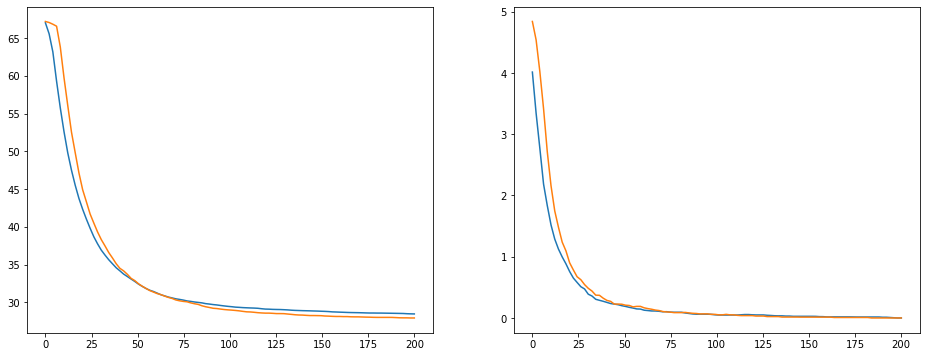

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(output_MIS_Thorlabs['radiation_output'][0],output_MIS_Thorlabs['radiation_output'][1])
ax1.plot(output_MIS['radiation_output'][0],output_MIS['radiation_output'][1])
ax2.plot(output_MIS_Thorlabs['radiation_output'][0],output_MIS_Thorlabs['radiation_output'][2])
ax2.plot(output_MIS['radiation_output'][0],output_MIS['radiation_output'][2])

C:\Users\nikom\AppData\Local\Temp\ipykernel_4612\3600550660.py:4: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(output_MIS_Thorlabs['radiation_output'][0],np.log10(output_MIS_Thorlabs['radiation_output'][2]))
C:\Users\nikom\AppData\Local\Temp\ipykernel_4612\3600550660.py:5: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(output_MIS['radiation_output'][0],np.log10(output_MIS['radiation_output'][2]))


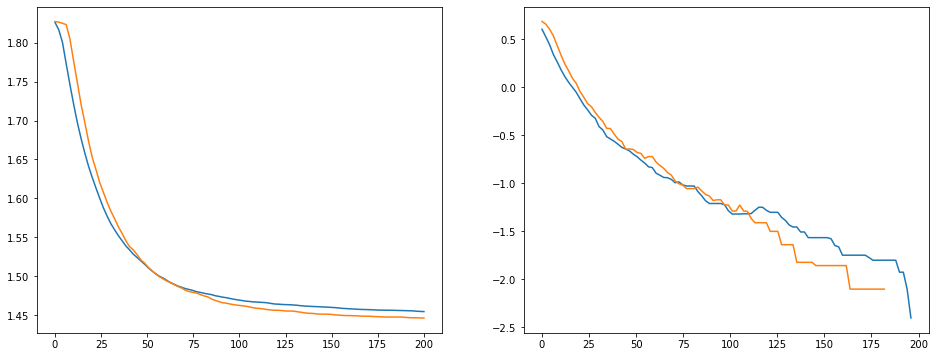

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(output_MIS_Thorlabs['radiation_output'][0],np.log10(output_MIS_Thorlabs['radiation_output'][1]))
ax1.plot(output_MIS['radiation_output'][0],np.log10(output_MIS['radiation_output'][1]))
ax2.plot(output_MIS_Thorlabs['radiation_output'][0],np.log10(output_MIS_Thorlabs['radiation_output'][2]))
ax2.plot(output_MIS['radiation_output'][0],np.log10(output_MIS['radiation_output'][2]))

In [102]:
#cProfile.run("mlmc(parameters, geometry)",sort='tottime')